"""
=============================================================================
ADVANCED EXPLORATORY DATA ANALYSIS & FEATURE ENGINEERING
Risk-Based Authentication System for Zero Trust GitLab Security
=============================================================================

PURPOSE:
This script performs deep analysis and feature engineering on login data to:
1. Identify attack patterns and anomalous behavior
2. Create ML-ready features for risk scoring
3. Understand user behavior baselines
4. Detect account takeover indicators
5. Build features for LightGBM risk prediction model

GOAL:
Transform raw login data into meaningful risk indicators that can predict:
- Low Risk (0.00-0.29): Allow login
- Medium Risk (0.30-0.69): Require step-up MFA
- High Risk (0.70-1.00): Block login + alert security team

DATASET: RBA Dataset - 312,706 login events (10% sample of 33M records)
"""

In [ ]:
import pkg_resources
import subprocess
import sys

with open("requirements.txt", "r") as f:
    packages = f.read().splitlines()

for pkg in packages:
    try:
        pkg_resources.require(pkg)
        print(f"{pkg} is already installed.")
    except pkg_resources.DistributionNotFound:
        print(f"{pkg} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("dasgroup/rba-dataset")

# print("Path to dataset files:", path)

In [4]:
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 70)
print("RISK-BASED AUTHENTICATION SYSTEM - EDA")
print("=" * 70)

RISK-BASED AUTHENTICATION SYSTEM - EDA


In [5]:
# ============================================================================
# STEP 1: LOAD DATASET
# ============================================================================

try:
    # Method 1: Load 10% of rows using skiprows (faster, less memory)
    # This randomly skips 90% of rows while loading
    
    # First, get total line count (optional, for progress tracking)
    print("Loading 10% sample of the dataset...")
    
    # Load with random sampling - skiprows with lambda function
    # This keeps approximately 10% of rows
    df = pd.read_csv(
        'C:/Users/Sai/Desktop/Dissertation Code/rba-dataset.csv',
        skiprows=lambda i: i > 0 and np.random.random() > 0.01,  # Keep 10% of rows
        low_memory=False
    )
    
    print(f"  Dataset sample loaded successfully!")
    print(f"  Sample Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"  Estimated Full Dataset: ~{df.shape[0] * 10:,} rows")
    print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("Dataset file not found!")
    print("\nTo download the dataset:")
    print("1. Visit: https://www.kaggle.com/datasets/dasgroup/rba-dataset")
    print("2. Download the CSV file")
    print("3. Place it in the same directory as this script")
    print("4. Update the filename in the code if needed")
    exit()
except MemoryError:
    print("Memory error! Trying with smaller sample (5%)...")
    try:
        df = pd.read_csv(
            'C:/Users/Sai/Desktop/Dissertation Code/rba-dataset.csv',
            skiprows=lambda i: i > 0 and np.random.random() > 0.05,  # Keep 5% of rows
            low_memory=False
        )
        print(f"  5% sample loaded successfully!")
        print(f"  Sample Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    except:
        print("Unable to load dataset. Try further reducing sample size.")
        exit()


Loading 10% sample of the dataset...
  Dataset sample loaded successfully!
  Sample Shape: 312,898 rows × 16 columns
  Estimated Full Dataset: ~3,128,980 rows
  Memory Usage: 209.29 MB


In [6]:
# ============================================================================
# STEP 2: INITIAL DATA INSPECTION
# ============================================================================
print("\n[STEP 2] Initial Data Inspection")
print("-" * 70)

print("\nDataset Info:")
print(df.info())

print("\nFirst 5 Rows:")
print(df.head())

print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes.value_counts())


[STEP 2] Initial Data Inspection
----------------------------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312898 entries, 0 to 312897
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   index                     312898 non-null  int64  
 1   Login Timestamp           312898 non-null  object 
 2   User ID                   312898 non-null  int64  
 3   Round-Trip Time [ms]      12678 non-null   float64
 4   IP Address                312898 non-null  object 
 5   Country                   312898 non-null  object 
 6   Region                    312455 non-null  object 
 7   City                      312802 non-null  object 
 8   ASN                       312898 non-null  int64  
 9   User Agent String         312898 non-null  object 
 10  Browser Name and Version  312898 non-null  object 
 11  OS Name and Version       312898 non

In [7]:
# ============================================================================
# STEP 3: BASIC STATISTICS
# ============================================================================
print("\n[STEP 3] Basic Statistics")
print("-" * 70)

print("\nNumerical Features Summary:")
print(df.describe())

print("\nCategorical Features Summary:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols[:5]:  # Show first 5 categorical columns
    print(f"\n{col}:")
    print(df[col].value_counts().head())



[STEP 3] Basic Statistics
----------------------------------------------------------------------

Numerical Features Summary:
              index       User ID  Round-Trip Time [ms]            ASN
count  3.128980e+05  3.128980e+05          12678.000000  312898.000000
mean   1.562412e+07 -1.933730e+18            663.429563  162405.397746
std    9.021080e+06  4.513427e+18            857.977336  172121.279009
min    1.600000e+01 -9.223264e+18             10.000000      12.000000
25%    7.800392e+06 -4.324476e+18            473.000000   29695.000000
50%    1.564734e+07 -4.324476e+18            540.000000   41164.000000
75%    2.342675e+07  9.001291e+17            685.000000  393398.000000
max    3.126923e+07  9.223159e+18          40177.000000  507696.000000

Categorical Features Summary:

Login Timestamp:
Login Timestamp
2020-02-03 12:44:31.854    1
2020-02-03 12:47:01.405    1
2020-02-03 12:47:50.977    1
2020-02-03 12:48:59.356    1
2020-02-03 12:52:38.107    1
Name: count, dtype: int6

In [8]:
# ============================================================================
# STEP 4: MISSING VALUES ANALYSIS
# ============================================================================
print("\n[STEP 4] Missing Values Analysis")
print("-" * 70)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print("\nMissing Values:")
print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("No missing values found!")


[STEP 4] Missing Values Analysis
----------------------------------------------------------------------

Missing Values:
                      Missing_Count  Percentage
Round-Trip Time [ms]         300220   95.948200
Region                          443    0.141580
City                             96    0.030681
Device Type                      21    0.006711


In [9]:

# ============================================================================
# STEP 5: TARGET VARIABLE ANALYSIS
# ============================================================================
print("\n[STEP 5] Target Variable Analysis")
print("-" * 70)

# Identify potential target columns
target_candidates = ['label', 'is_attack', 'is_fraud', 'result', 'status', 
                     'is_successful', 'attack', 'malicious']

target_col = None
for col in target_candidates:
    if col in df.columns:
        target_col = col
        break

if target_col:
    print(f"\nTarget Variable: '{target_col}'")
    print(f"\nDistribution:")
    print(df[target_col].value_counts())
    print(f"\nProportions:")
    print(df[target_col].value_counts(normalize=True))
    
    # Visualize target distribution
    plt.figure(figsize=(10, 5))
    df[target_col].value_counts().plot(kind='bar', color=['green', 'red'])
    plt.title(f'Distribution of {target_col}', fontsize=14, fontweight='bold')
    plt.xlabel(target_col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
    print("\nSaved: target_distribution.png")
else:
    print("Target column not identified automatically")
    print(f"Available columns: {df.columns.tolist()}")



[STEP 5] Target Variable Analysis
----------------------------------------------------------------------
Target column not identified automatically
Available columns: ['index', 'Login Timestamp', 'User ID', 'Round-Trip Time [ms]', 'IP Address', 'Country', 'Region', 'City', 'ASN', 'User Agent String', 'Browser Name and Version', 'OS Name and Version', 'Device Type', 'Login Successful', 'Is Attack IP', 'Is Account Takeover']



[1.1] Attack Distribution Analysis
--------------------------------------------------------------------------------

Security Event Statistics:
       Login Success  Attack IP  Account Takeover
False         187417     282014            312897
True          125481      30884                 1

Percentages:
       Login Success  Attack IP  Account Takeover
False      59.897155  90.129691          99.99968
True       40.102845   9.870309           0.00032
THREAT METRICS:
  • Attack IP Rate: 9.87%
  • Account Takeover Rate: 0.00%
  • Failed Login Rate: 59.90%
  • Class Imbalance Ratio: 1:10 (attacks:legitimate)


 Saved: security_threat_landscape.png


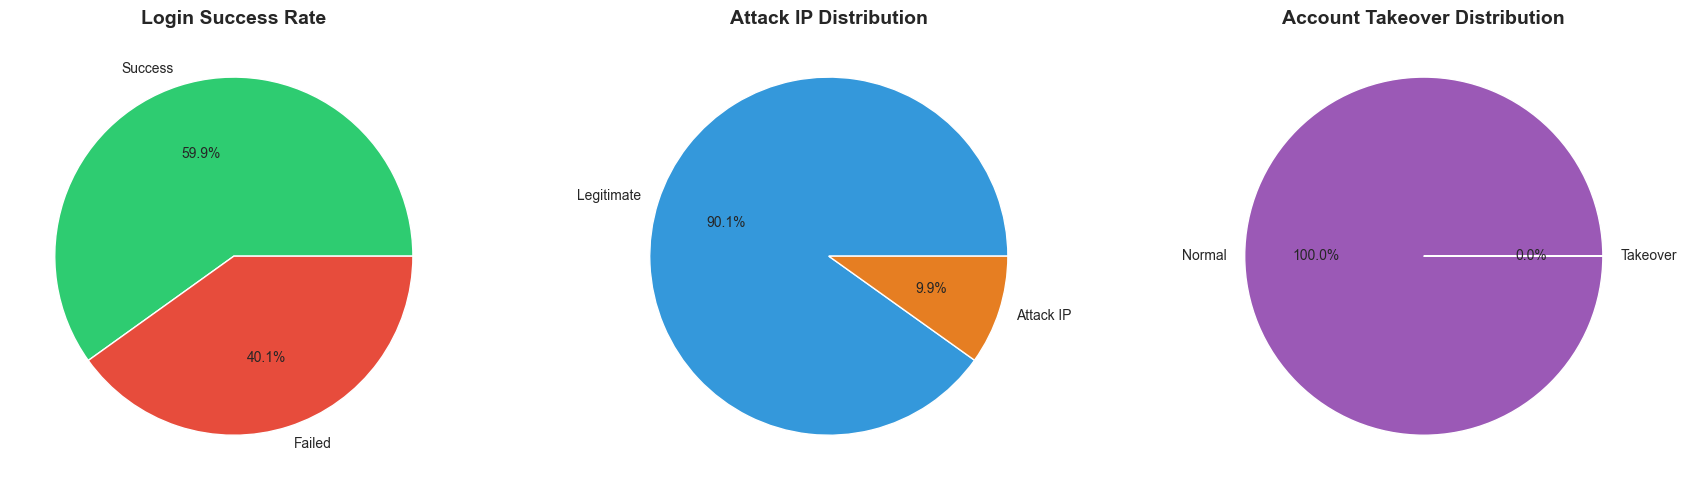

In [10]:
# -----------------------------------------------------------------------------
# 1.1 Attack Distribution Analysis
# PURPOSE: Understand the threat landscape and attack prevalence
# USE: Determine if data is imbalanced, guide sampling strategy
# -----------------------------------------------------------------------------
print("\n[1.1] Attack Distribution Analysis")
print("-" * 80)

attack_stats = pd.DataFrame({
    'Login Success': df['Login Successful'].value_counts(),
    'Attack IP': df['Is Attack IP'].value_counts(),
    'Account Takeover': df['Is Account Takeover'].value_counts()
})

print("\nSecurity Event Statistics:")
print(attack_stats)
print("\nPercentages:")
print(attack_stats / len(df) * 100)

# Calculate class imbalance ratio
attack_ratio = df['Is Attack IP'].sum() / len(df)
takeover_ratio = df['Is Account Takeover'].sum() / len(df)
failed_login_ratio = (~df['Login Successful']).sum() / len(df)

print(f"""THREAT METRICS:
  • Attack IP Rate: {attack_ratio:.2%}
  • Account Takeover Rate: {takeover_ratio:.2%}
  • Failed Login Rate: {failed_login_ratio:.2%}
  • Class Imbalance Ratio: 1:{int(1/attack_ratio)} (attacks:legitimate)
""")

# Visualize security threats
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Login Success vs Failure
df['Login Successful'].value_counts().plot(kind='pie', ax=axes[0], autopct='%1.1f%%',
                                            colors=['#2ecc71', '#e74c3c'],
                                            labels=['Success', 'Failed'])
axes[0].set_title('Login Success Rate', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# Plot 2: Attack IP Distribution
df['Is Attack IP'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                        colors=['#3498db', '#e67e22'],
                                        labels=['Legitimate', 'Attack IP'])
axes[1].set_title('Attack IP Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

# Plot 3: Account Takeover
df['Is Account Takeover'].value_counts().plot(kind='pie', ax=axes[2], autopct='%1.1f%%',
                                               colors=['#9b59b6', '#c0392b'],
                                               labels=['Normal', 'Takeover'])
axes[2].set_title('Account Takeover Distribution', fontsize=14, fontweight='bold')
axes[2].set_ylabel('')

plt.tight_layout()
plt.savefig('security_threat_landscape.png', dpi=300, bbox_inches='tight')
print("\n Saved: security_threat_landscape.png")


[1.2] Temporal Attack Pattern Analysis
--------------------------------------------------------------------------------

Attack Rate by Hour of Day:
       sum  attack_rate
hour                   
0      361     8.257091
1      673    13.193491
2     1125    16.846361
3     1261    17.116873
4     1510    17.488997
5     1520    14.552417
6     1638    12.415675
7     1630    10.533118
8     1600     9.640296
9     1613     9.283988

Saved: temporal_attack_patterns.png


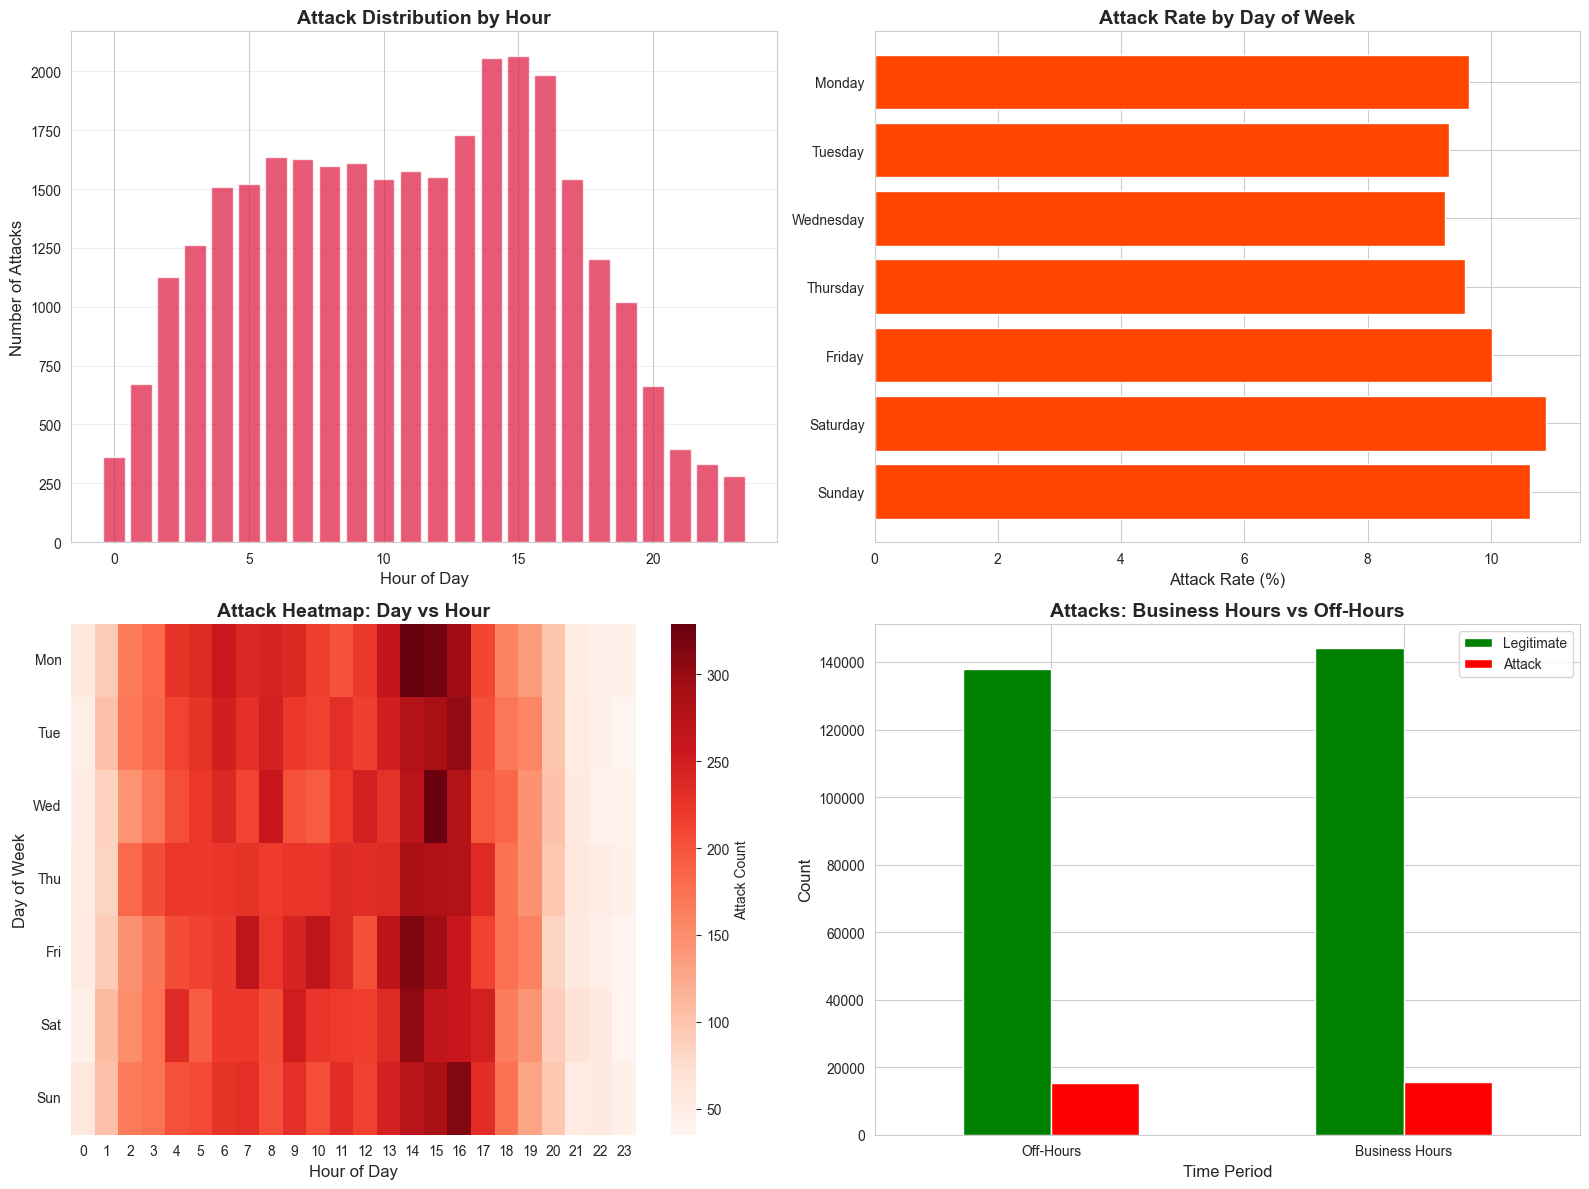

In [11]:
# -----------------------------------------------------------------------------
# 1.2 Attack Patterns by Time
# PURPOSE: Identify when attacks occur most frequently
# USE: Create temporal risk factors, adjust thresholds by time
# -----------------------------------------------------------------------------
print("\n[1.2] Temporal Attack Pattern Analysis")
print("-" * 80)

df['Login Timestamp'] = pd.to_datetime(df['Login Timestamp'])
df['hour'] = df['Login Timestamp'].dt.hour
df['day_of_week'] = df['Login Timestamp'].dt.dayofweek
df['day_name'] = df['Login Timestamp'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin([5, 6])
df['is_business_hours'] = df['hour'].between(9, 17)

# Attack rates by hour
attack_by_hour = df.groupby('hour')['Is Attack IP'].agg(['sum', 'count', 'mean'])
attack_by_hour['attack_rate'] = attack_by_hour['mean'] * 100

print("\nAttack Rate by Hour of Day:")
print(attack_by_hour[['sum', 'attack_rate']].head(10))

# Visualization: Heatmap of attacks by time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Attacks by Hour
axes[0, 0].bar(attack_by_hour.index, attack_by_hour['sum'], color='crimson', alpha=0.7)
axes[0, 0].set_xlabel('Hour of Day', fontsize=12)
axes[0, 0].set_ylabel('Number of Attacks', fontsize=12)
axes[0, 0].set_title('Attack Distribution by Hour', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Attack Rate by Day of Week
attack_by_day = df.groupby('day_name')['Is Attack IP'].mean() * 100
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
attack_by_day = attack_by_day.reindex(day_order)
axes[0, 1].barh(attack_by_day.index, attack_by_day.values, color='orangered')
axes[0, 1].set_xlabel('Attack Rate (%)', fontsize=12)
axes[0, 1].set_title('Attack Rate by Day of Week', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

# Plot 3: Heatmap - Hour vs Day of Week
pivot_attacks = df.groupby(['day_of_week', 'hour'])['Is Attack IP'].sum().unstack(fill_value=0)
sns.heatmap(pivot_attacks, cmap='Reds', ax=axes[1, 0], cbar_kws={'label': 'Attack Count'})
axes[1, 0].set_xlabel('Hour of Day', fontsize=12)
axes[1, 0].set_ylabel('Day of Week', fontsize=12)
axes[1, 0].set_title('Attack Heatmap: Day vs Hour', fontsize=14, fontweight='bold')
axes[1, 0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

# Plot 4: Business Hours vs Off-Hours Attacks
business_hours_attacks = df.groupby(['is_business_hours', 'Is Attack IP']).size().unstack()
business_hours_attacks.plot(kind='bar', ax=axes[1, 1], color=['green', 'red'])
axes[1, 1].set_xlabel('Time Period', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Attacks: Business Hours vs Off-Hours', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(['Off-Hours', 'Business Hours'], rotation=0)
axes[1, 1].legend(['Legitimate', 'Attack'])

plt.tight_layout()
plt.savefig('temporal_attack_patterns.png', dpi=300, bbox_inches='tight')
print("\nSaved: temporal_attack_patterns.png")


[1.3] Geographic Attack Distribution
--------------------------------------------------------------------------------

Top 10 Countries by Attack Volume:
         attack_count  attack_rate  total_logins
Country                                         
US              24181       0.2778         87056
NO               1530       0.0116        132157
PL                887       0.1045          8486
ID                747       0.2390          3125
RO                637       0.5040          1264
DE                558       0.0619          9017
AU                439       0.1120          3920
IN                240       0.0554          4334
GB                214       0.0507          4219
RU                195       0.0114         17108

 High-Risk Countries (attack rate > 5%): 77
         attack_count  attack_rate  total_logins
Country                                         
US              24181       0.2778         87056
PL                887       0.1045          8486
ID              

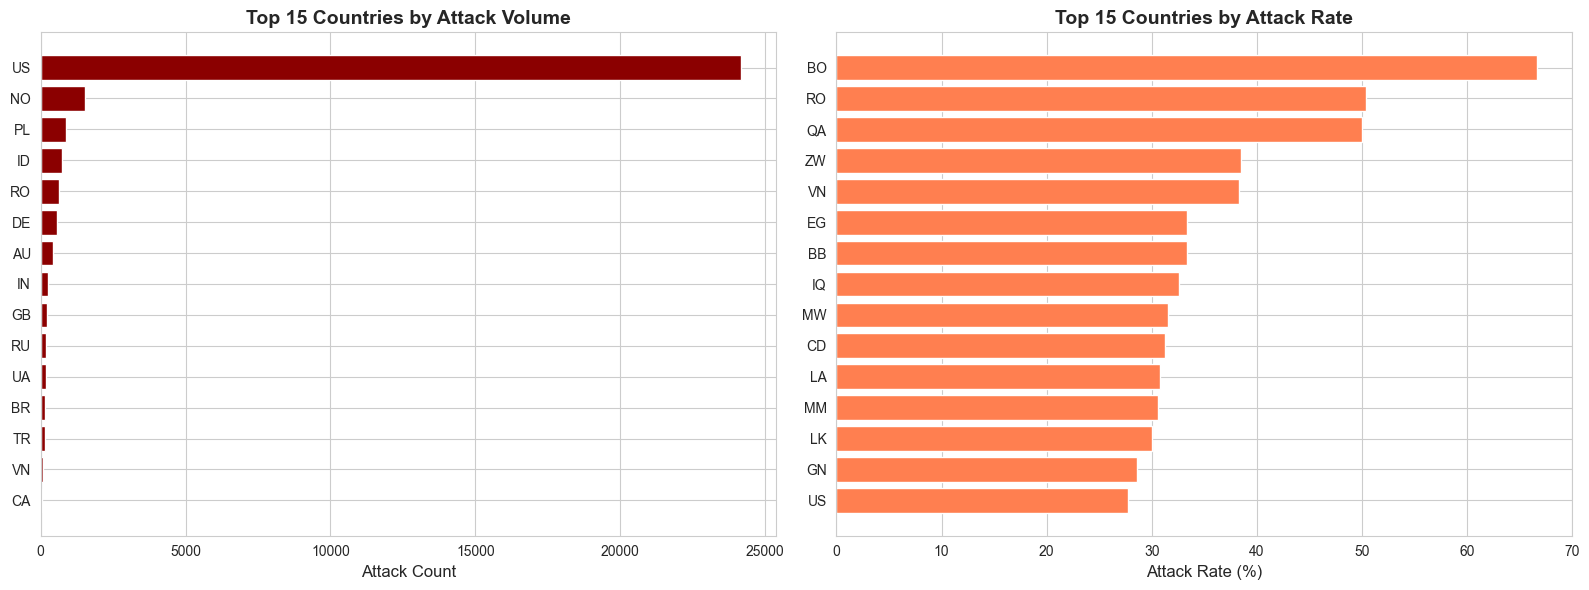

In [12]:
# -----------------------------------------------------------------------------
# 1.3 Geographic Attack Analysis
# PURPOSE: Identify high-risk countries and regions
# USE: Create geographic risk scores, flag unusual locations
# -----------------------------------------------------------------------------
print("\n[1.3] Geographic Attack Distribution")
print("-" * 80)

# Attack rates by country
country_attacks = df.groupby('Country').agg({
    'Is Attack IP': ['sum', 'mean', 'count']
}).round(4)
country_attacks.columns = ['attack_count', 'attack_rate', 'total_logins']
country_attacks = country_attacks.sort_values('attack_count', ascending=False)

print("\nTop 10 Countries by Attack Volume:")
print(country_attacks.head(10))

# High-risk countries (attack rate > 5%)
high_risk_countries = country_attacks[country_attacks['attack_rate'] > 0.05]
print(f"\n High-Risk Countries (attack rate > 5%): {len(high_risk_countries)}")
print(high_risk_countries)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top countries by attack count
top_attack_countries = country_attacks.head(15)
axes[0].barh(range(len(top_attack_countries)), top_attack_countries['attack_count'], 
             color='darkred')
axes[0].set_yticks(range(len(top_attack_countries)))
axes[0].set_yticklabels(top_attack_countries.index)
axes[0].set_xlabel('Attack Count', fontsize=12)
axes[0].set_title('Top 15 Countries by Attack Volume', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Plot 2: Attack rate by country
top_rate_countries = country_attacks.nlargest(15, 'attack_rate')
axes[1].barh(range(len(top_rate_countries)), top_rate_countries['attack_rate'] * 100,
             color='coral')
axes[1].set_yticks(range(len(top_rate_countries)))
axes[1].set_yticklabels(top_rate_countries.index)
axes[1].set_xlabel('Attack Rate (%)', fontsize=12)
axes[1].set_title('Top 15 Countries by Attack Rate', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('geographic_attack_analysis.png', dpi=300, bbox_inches='tight')
print("\n Saved: geographic_attack_analysis.png")



[1.4] Device & Browser Attack Analysis
--------------------------------------------------------------------------------

Attack Patterns by Device Type:
             attack_count  attack_rate   total
Device Type                                   
bot                   292     0.014251   20490
desktop              2246     0.028340   79252
mobile              27577     0.140379  196447
tablet                223     0.028157    7920
unknown               539     0.061474    8768

 Top Browsers Used in Attacks:
                attack_count  attack_rate   total
Browser_Family                                   
Chrome                 24111     0.122308  197133
Firefox                 3060     0.109462   27955
Android                  835     0.026298   31751
VLC                      435     0.060848    7149
Opera                    417     0.028327   14721
Snapchat                 344     0.299913    1147
Safari                   233     0.273796     851
Linkbot                  221     0.

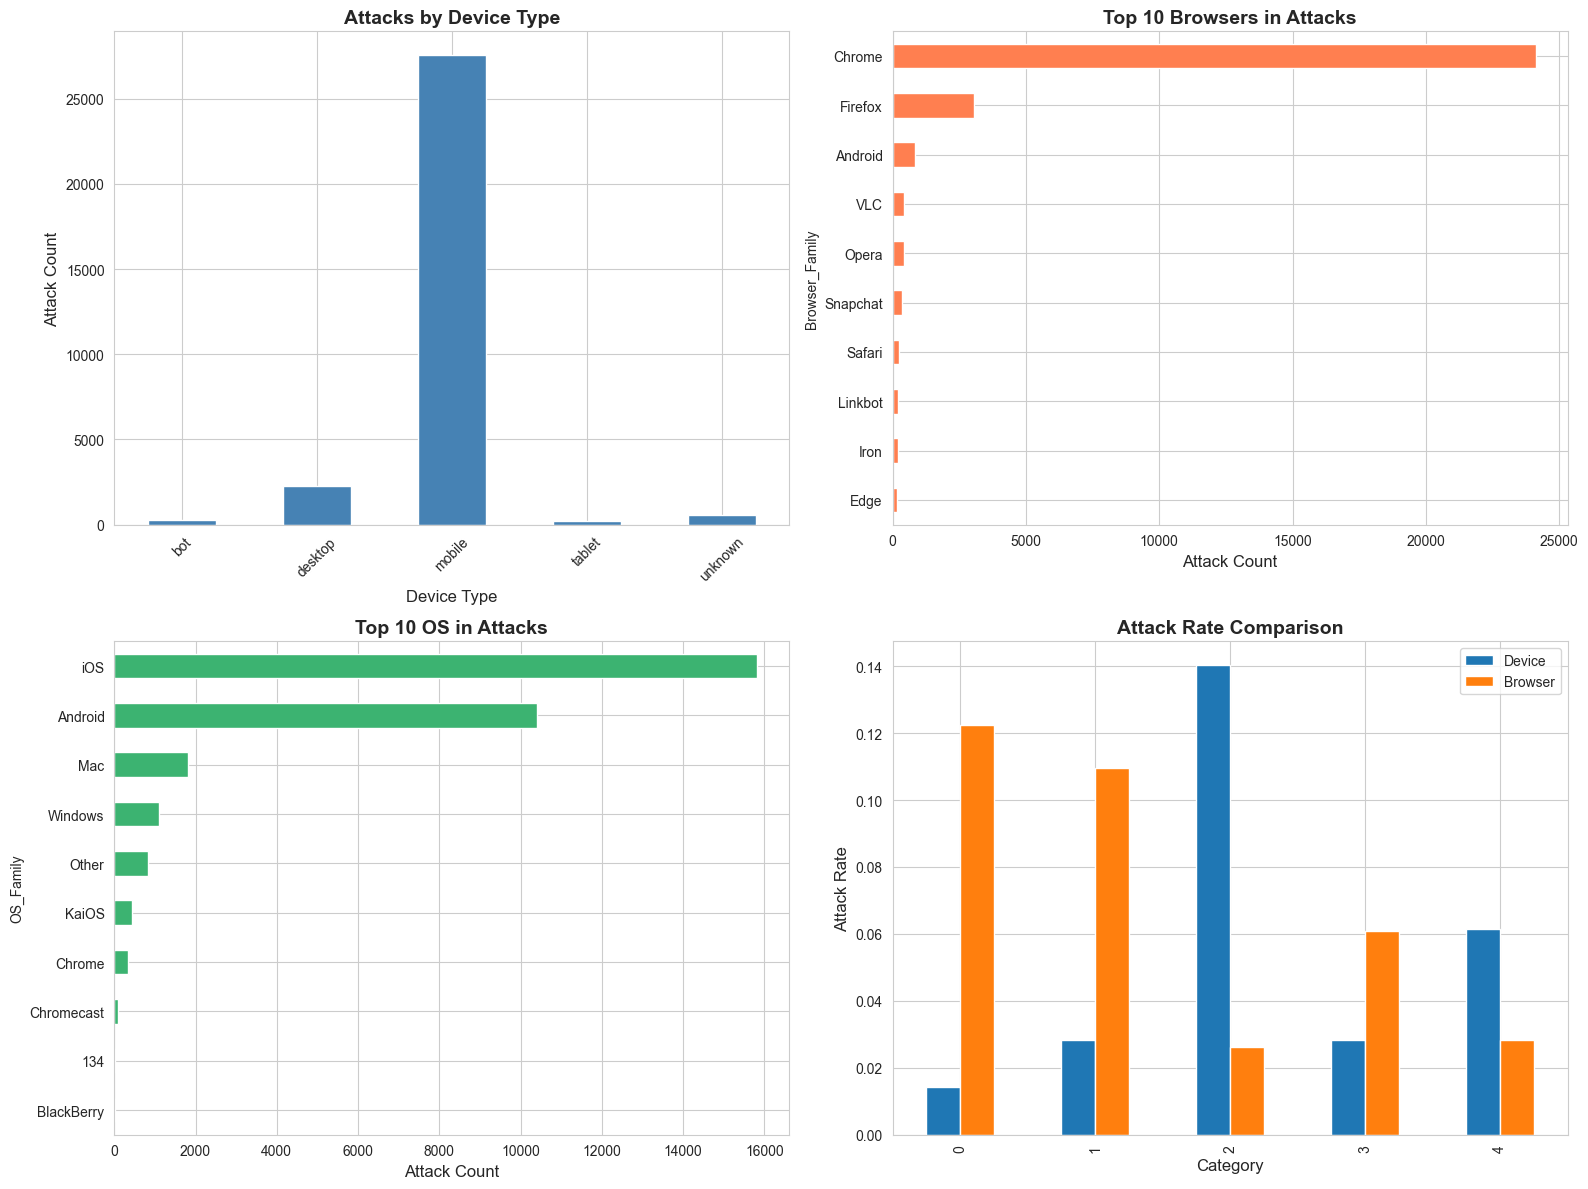

In [13]:
# -----------------------------------------------------------------------------
# 1.4 Device & Browser Attack Patterns
# PURPOSE: Identify suspicious devices and browsers used in attacks
# USE: Create device risk scores, detect unusual user agents
# -----------------------------------------------------------------------------
print("\n[1.4] Device & Browser Attack Analysis")
print("-" * 80)

# Parse device types
device_attacks = df.groupby('Device Type').agg({
    'Is Attack IP': ['sum', 'mean'],
    'User ID': 'count'
})
device_attacks.columns = ['attack_count', 'attack_rate', 'total']
print("\nAttack Patterns by Device Type:")
print(device_attacks)

# Browser analysis
df['Browser_Family'] = df['Browser Name and Version'].str.split().str[0]
browser_attacks = df.groupby('Browser_Family').agg({
    'Is Attack IP': ['sum', 'mean'],
    'User ID': 'count'
}).sort_values(('Is Attack IP', 'sum'), ascending=False)
browser_attacks.columns = ['attack_count', 'attack_rate', 'total']
print("\n Top Browsers Used in Attacks:")
print(browser_attacks.head(10))

# OS analysis
df['OS_Family'] = df['OS Name and Version'].str.split().str[0]
os_attacks = df.groupby('OS_Family').agg({
    'Is Attack IP': ['sum', 'mean'],
    'User ID': 'count'
}).sort_values(('Is Attack IP', 'sum'), ascending=False)
os_attacks.columns = ['attack_count', 'attack_rate', 'total']
print("\nOperating Systems in Attacks:")
print(os_attacks.head(10))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Device type distribution
device_attacks.plot(kind='bar', y='attack_count', ax=axes[0, 0], color='steelblue', legend=False)
axes[0, 0].set_xlabel('Device Type', fontsize=12)
axes[0, 0].set_ylabel('Attack Count', fontsize=12)
axes[0, 0].set_title('Attacks by Device Type', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Browser family attacks
browser_attacks.head(10).plot(kind='barh', y='attack_count', ax=axes[0, 1], 
                               color='coral', legend=False)
axes[0, 1].set_xlabel('Attack Count', fontsize=12)
axes[0, 1].set_title('Top 10 Browsers in Attacks', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

# Plot 3: OS family attacks
os_attacks.head(10).plot(kind='barh', y='attack_count', ax=axes[1, 0],
                          color='mediumseagreen', legend=False)
axes[1, 0].set_xlabel('Attack Count', fontsize=12)
axes[1, 0].set_title('Top 10 OS in Attacks', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()

# Plot 4: Attack rate comparison
comparison_data = pd.DataFrame({
    'Device': device_attacks['attack_rate'].values,
    'Browser': browser_attacks.head(len(device_attacks))['attack_rate'].values
})
comparison_data.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Category', fontsize=12)
axes[1, 1].set_ylabel('Attack Rate', fontsize=12)
axes[1, 1].set_title('Attack Rate Comparison', fontsize=14, fontweight='bold')
axes[1, 1].legend(['Device', 'Browser'])

plt.tight_layout()
plt.savefig('device_browser_attack_patterns.png', dpi=300, bbox_inches='tight')
print("\nSaved: device_browser_attack_patterns.png")

In [14]:
# =============================================================================
# PART 2: FEATURE ENGINEERING FOR ML RISK SCORING
# =============================================================================
print("\n" + "=" * 80)
print("PART 2: FEATURE ENGINEERING FOR RISK PREDICTION")
print("=" * 80)

# -----------------------------------------------------------------------------
# 2.1 Temporal Features
# PURPOSE: Capture time-based behavior patterns
# USE: Detect logins at unusual hours, measure login velocity
# -----------------------------------------------------------------------------
print("\n[2.1] Creating Temporal Risk Features")
print("-" * 80)

# Time-based features (already created above)
df['minute'] = df['Login Timestamp'].dt.minute
df['month'] = df['Login Timestamp'].dt.month
df['week_of_year'] = df['Login Timestamp'].dt.isocalendar().week

# Time since last login (per user)
df = df.sort_values(['User ID', 'Login Timestamp'])
df['time_since_last_login'] = df.groupby('User ID')['Login Timestamp'].diff().dt.total_seconds()
df['time_since_last_login'] = df['time_since_last_login'].fillna(0)

# Login velocity (logins per hour for each user)
# Method: Count logins in rolling window of last 5 attempts as proxy
df['login_count_last_hour'] = df.groupby('User ID').cumcount() + 1
df['login_count_recent'] = df.groupby('User ID')['Login Timestamp'].transform(
    lambda x: x.expanding().count()
)

# Alternative: Calculate actual hourly velocity based on time gaps
def calculate_login_velocity(group):
    """Calculate logins per hour based on recent activity"""
    group = group.sort_values('Login Timestamp')
    
    # For each login, count how many logins happened in the last hour
    result = []
    for idx, current_time in enumerate(group['Login Timestamp']):
        one_hour_ago = current_time - pd.Timedelta(hours=1)
        count = ((group['Login Timestamp'] <= current_time) & 
                 (group['Login Timestamp'] >= one_hour_ago)).sum()
        result.append(count)
    
    return pd.Series(result, index=group.index)

df['login_velocity'] = df.groupby('User ID').apply(
    lambda x: calculate_login_velocity(x)
).reset_index(level=0, drop=True)

print("Created temporal features:")
print("  • hour, day_of_week, is_weekend, is_business_hours")
print("  • time_since_last_login (seconds)")
print("  • login_count_last_hour (velocity metric)")



PART 2: FEATURE ENGINEERING FOR RISK PREDICTION

[2.1] Creating Temporal Risk Features
--------------------------------------------------------------------------------
Created temporal features:
  • hour, day_of_week, is_weekend, is_business_hours
  • time_since_last_login (seconds)
  • login_count_last_hour (velocity metric)


In [15]:
# -----------------------------------------------------------------------------
# 2.2 Geographic Risk Features
# PURPOSE: Detect impossible travel and unusual locations
# USE: Flag logins from high-risk countries, detect location changes
# -----------------------------------------------------------------------------
print("\n[2.2] Creating Geographic Risk Features")
print("-" * 80)

# Country risk score (based on attack rate)
country_risk = country_attacks['attack_rate'].to_dict()
df['country_risk_score'] = df['Country'].map(country_risk).fillna(0)

# Location change detection
df['country_changed'] = (df.groupby('User ID')['Country'].shift() != df['Country']).astype(int)
df['region_changed'] = (df.groupby('User ID')['Region'].shift() != df['Region']).astype(int)

# Count unique locations per user
user_location_diversity = df.groupby('User ID').agg({
    'Country': 'nunique',
    'Region': 'nunique',
    'City': 'nunique'
}).add_suffix('_count')

df = df.merge(user_location_diversity, left_on='User ID', right_index=True, how='left')

print("Created geographic features:")
print("  • country_risk_score (0-1 scale)")
print("  • country_changed, region_changed (binary flags)")
print("  • Country_count, Region_count, City_count (diversity metrics)")



[2.2] Creating Geographic Risk Features
--------------------------------------------------------------------------------
Created geographic features:
  • country_risk_score (0-1 scale)
  • country_changed, region_changed (binary flags)
  • Country_count, Region_count, City_count (diversity metrics)


In [16]:

# -----------------------------------------------------------------------------
# 2.3 Network & IP Features
# PURPOSE: Identify suspicious IPs and network patterns
# USE: Flag known attack IPs, detect IP changes
# -----------------------------------------------------------------------------
print("\n[2.3] Creating Network Risk Features")
print("-" * 80)

# IP reputation (how many times IP was used in attacks)
ip_reputation = df.groupby('IP Address')['Is Attack IP'].agg(['sum', 'count', 'mean'])
ip_reputation.columns = ['ip_attack_count', 'ip_total_uses', 'ip_attack_rate']
df = df.merge(ip_reputation, left_on='IP Address', right_index=True, how='left')

# ASN risk score
asn_risk = df.groupby('ASN')['Is Attack IP'].mean()
df['asn_risk_score'] = df['ASN'].map(asn_risk).fillna(0)

# IP change detection
df['ip_changed'] = (df.groupby('User ID')['IP Address'].shift() != df['IP Address']).astype(int)

# Unique IPs per user
user_ip_count = df.groupby('User ID')['IP Address'].nunique()
df['user_ip_diversity'] = df['User ID'].map(user_ip_count)

print("Created network features:")
print("  • ip_attack_rate (IP reputation)")
print("  • asn_risk_score (network provider risk)")
print("  • ip_changed (binary flag)")
print("  • user_ip_diversity (unique IPs per user)")



[2.3] Creating Network Risk Features
--------------------------------------------------------------------------------
Created network features:
  • ip_attack_rate (IP reputation)
  • asn_risk_score (network provider risk)
  • ip_changed (binary flag)
  • user_ip_diversity (unique IPs per user)


In [17]:
# -----------------------------------------------------------------------------
# 2.4 Device & Browser Consistency Features
# PURPOSE: Detect device/browser changes indicating account compromise
# USE: Flag unusual user agents, measure device stability
# -----------------------------------------------------------------------------
print("\n[2.4] Creating Device Consistency Features")
print("-" * 80)

# Device change detection
df['device_changed'] = (df.groupby('User ID')['Device Type'].shift() != df['Device Type']).astype(int)
df['browser_changed'] = (df.groupby('User ID')['Browser_Family'].shift() != df['Browser_Family']).astype(int)
df['os_changed'] = (df.groupby('User ID')['OS_Family'].shift() != df['OS_Family']).astype(int)

# User agent stability
user_agent_count = df.groupby('User ID')['User Agent String'].nunique()
df['user_agent_diversity'] = df['User ID'].map(user_agent_count)

# Device type risk
device_risk = df.groupby('Device Type')['Is Attack IP'].mean()
df['device_risk_score'] = df['Device Type'].map(device_risk).fillna(0)

print("Created device consistency features:")
print("  • device_changed, browser_changed, os_changed (binary flags)")
print("  • user_agent_diversity (stability metric)")
print("  • device_risk_score (device type risk)")


[2.4] Creating Device Consistency Features
--------------------------------------------------------------------------------
Created device consistency features:
  • device_changed, browser_changed, os_changed (binary flags)
  • user_agent_diversity (stability metric)
  • device_risk_score (device type risk)


In [18]:
# -----------------------------------------------------------------------------
# 2.5 Behavioral Baseline Features
# PURPOSE: Model normal user behavior and detect deviations
# USE: Compare current login to user's historical patterns
# -----------------------------------------------------------------------------
print("\n[2.5] Creating Behavioral Baseline Features")
print("-" * 80)

# User login frequency
user_login_stats = df.groupby('User ID').agg({
    'Login Timestamp': 'count',
    'Login Successful': 'mean',
    'Round-Trip Time [ms]': 'mean'
}).rename(columns={
    'Login Timestamp': 'total_logins',
    'Login Successful': 'success_rate',
    'Round-Trip Time [ms]': 'avg_rtt'
})

df = df.merge(user_login_stats, left_on='User ID', right_index=True, how='left')

# Recent failed login count (last 5 logins per user)
df['recent_failed_logins'] = df.groupby('User ID')['Login Successful'].transform(
    lambda x: (~x).rolling(window=5, min_periods=1).sum()
)

# RTT deviation from user average
df['rtt_deviation'] = abs(df['Round-Trip Time [ms]'] - df['avg_rtt']) / (df['avg_rtt'] + 1)
df['rtt_deviation'] = df['rtt_deviation'].fillna(0)

print("Created behavioral features:")
print("  • total_logins (user activity level)")
print("  • success_rate (historical success rate)")
print("  • recent_failed_logins (last 5 attempts)")
print("  • rtt_deviation (network anomaly score)")


[2.5] Creating Behavioral Baseline Features
--------------------------------------------------------------------------------
Created behavioral features:
  • total_logins (user activity level)
  • success_rate (historical success rate)
  • recent_failed_logins (last 5 attempts)
  • rtt_deviation (network anomaly score)


In [19]:
# -----------------------------------------------------------------------------
# 2.6 Composite Risk Scores
# PURPOSE: Combine multiple signals into aggregate risk indicators
# USE: Pre-computed risk scores for faster inference
# -----------------------------------------------------------------------------
print("\n[2.6] Creating Composite Risk Scores")
print("-" * 80)

# Geographic risk (normalized 0-1)
df['geo_risk'] = (
    df['country_risk_score'] * 0.4 +
    df['country_changed'] * 0.3 +
    (df['Country_count'] > 3).astype(int) * 0.3
)

# Network risk (normalized 0-1)
df['network_risk'] = (
    df['ip_attack_rate'] * 0.5 +
    df['asn_risk_score'] * 0.3 +
    df['ip_changed'] * 0.2
)

# Device risk (normalized 0-1)
df['device_risk'] = (
    df['device_risk_score'] * 0.4 +
    df['device_changed'] * 0.3 +
    df['browser_changed'] * 0.2 +
    (df['user_agent_diversity'] > 5).astype(int) * 0.1
)

# Behavioral risk (normalized 0-1)
df['behavioral_risk'] = (
    (df['recent_failed_logins'] / 5) * 0.4 +
    (df['time_since_last_login'] < 60).astype(int) * 0.3 +  # Less than 1 min
    df['rtt_deviation'].clip(0, 1) * 0.3
)

# Overall risk score (weighted average)
df['overall_risk_score'] = (
    df['geo_risk'] * 0.25 +
    df['network_risk'] * 0.35 +
    df['device_risk'] * 0.25 +
    df['behavioral_risk'] * 0.15
)

print("Created composite risk scores:")
print("  • geo_risk (geographic anomaly)")
print("  • network_risk (IP/network threat)")
print("  • device_risk (device inconsistency)")
print("  • behavioral_risk (unusual behavior)")
print("  • overall_risk_score (combined risk 0-1)")


[2.6] Creating Composite Risk Scores
--------------------------------------------------------------------------------
Created composite risk scores:
  • geo_risk (geographic anomaly)
  • network_risk (IP/network threat)
  • device_risk (device inconsistency)
  • behavioral_risk (unusual behavior)
  • overall_risk_score (combined risk 0-1)



 Saved: risk_score_distributions.png


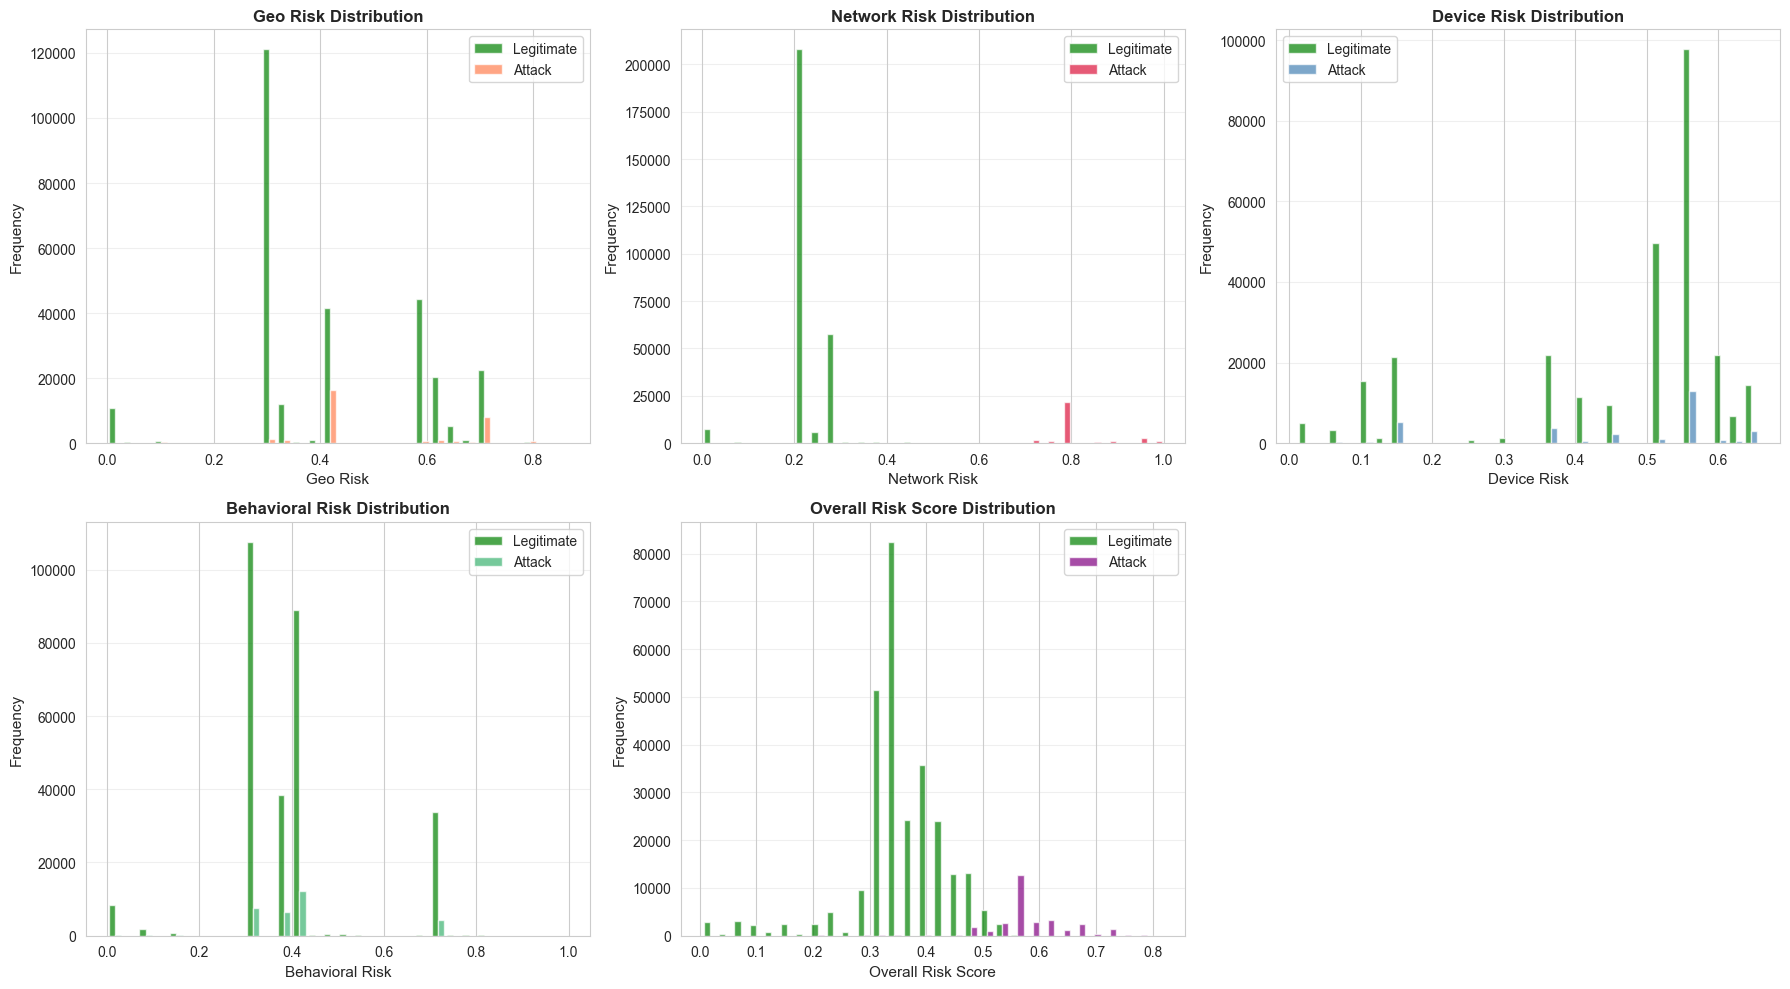

In [20]:
# Visualize risk score distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

risk_features = ['geo_risk', 'network_risk', 'device_risk', 'behavioral_risk', 'overall_risk_score']
colors = ['coral', 'crimson', 'steelblue', 'mediumseagreen', 'purple']

for idx, (risk_col, color) in enumerate(zip(risk_features, colors)):
    row = idx // 3
    col = idx % 3
    
    # Split by attack vs legitimate
    axes[row, col].hist([df[df['Is Attack IP'] == False][risk_col].dropna(),
                         df[df['Is Attack IP'] == True][risk_col].dropna()],
                        bins=30, alpha=0.7, label=['Legitimate', 'Attack'],
                        color=['green', color])
    axes[row, col].set_xlabel(risk_col.replace('_', ' ').title(), fontsize=11)
    axes[row, col].set_ylabel('Frequency', fontsize=11)
    axes[row, col].set_title(f'{risk_col.replace("_", " ").title()} Distribution', 
                             fontsize=12, fontweight='bold')
    axes[row, col].legend()
    axes[row, col].grid(axis='y', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.savefig('risk_score_distributions.png', dpi=300, bbox_inches='tight')
print("\n Saved: risk_score_distributions.png")


In [21]:
# =============================================================================
# PART 3: FEATURE SUMMARY & ML READINESS CHECK
# =============================================================================
print("\n" + "=" * 80)
print("PART 3: FEATURE ENGINEERING SUMMARY")
print("=" * 80)

# List all engineered features
engineered_features = [
    'hour', 'day_of_week', 'is_weekend', 'is_business_hours',
    'time_since_last_login', 'login_count_last_hour',
    'country_risk_score', 'country_changed', 'region_changed',
    'Country_count', 'Region_count', 'City_count',
    'ip_attack_rate', 'asn_risk_score', 'ip_changed', 'user_ip_diversity',
    'device_changed', 'browser_changed', 'os_changed', 
    'user_agent_diversity', 'device_risk_score',
    'total_logins', 'success_rate', 'recent_failed_logins', 'rtt_deviation',
    'geo_risk', 'network_risk', 'device_risk', 'behavioral_risk', 'overall_risk_score'
]

print(f"\n reated {len(engineered_features)} engineered features")
print("\nFeature Categories:")
print(f"  • Temporal: 6 features")
print(f"  • Geographic: 6 features")
print(f"  • Network: 4 features")
print(f"  • Device: 5 features")
print(f"  • Behavioral: 4 features")
print(f"  • Composite Risk: 5 features")

# Check for missing values in engineered features
missing_in_features = df[engineered_features].isnull().sum()
print(f"\n Missing values in engineered features:")
print(missing_in_features[missing_in_features > 0])

# Feature correlation with target
print("\nTop 15 Features Correlated with Attack:")
feature_target_corr = df[engineered_features + ['Is Attack IP']].corr()['Is Attack IP'].abs().sort_values(ascending=False)
print(feature_target_corr.head(15))

# Save processed dataset
output_file = 'rba_dataset_engineered.csv'
df.to_csv(output_file, index=False)
print(f"\n Saved engineered dataset: {output_file}")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)}")



PART 3: FEATURE ENGINEERING SUMMARY

 reated 30 engineered features

Feature Categories:
  • Temporal: 6 features
  • Geographic: 6 features
  • Network: 4 features
  • Device: 5 features
  • Behavioral: 4 features
  • Composite Risk: 5 features

 Missing values in engineered features:
Series([], dtype: int64)

Top 15 Features Correlated with Attack:
ip_attack_rate          1.000000
Is Attack IP            1.000000
network_risk            0.957703
overall_risk_score      0.642320
asn_risk_score          0.530259
country_risk_score      0.403368
device_risk_score       0.182796
geo_risk                0.144544
success_rate            0.097387
region_changed          0.076836
hour                    0.076821
recent_failed_logins    0.065490
user_ip_diversity       0.055910
Country_count           0.055910
user_agent_diversity    0.055910
Name: Is Attack IP, dtype: float64

 Saved engineered dataset: rba_dataset_engineered.csv
  Rows: 312,898
  Columns: 57


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_auc_score, roc_curve, accuracy_score,
                              precision_recall_curve, f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("ML MODEL TRAINING - RISK SCORING SYSTEM")
print("=" * 80)

# =============================================================================
# STEP 1: LOAD ENGINEERED DATASET
# =============================================================================
print("\n[STEP 1] Loading Engineered Dataset...")
print("-" * 80)

# Load the processed dataset with all engineered features
df = pd.read_csv('rba_dataset_engineered.csv')
print(f"Dataset loaded: {len(df):,} rows × {len(df.columns)} columns")

ML MODEL TRAINING - RISK SCORING SYSTEM

[STEP 1] Loading Engineered Dataset...
--------------------------------------------------------------------------------
Dataset loaded: 312,898 rows × 57 columns


In [23]:
# =============================================================================
# STEP 2: PREPARE FEATURES AND TARGET
# =============================================================================
print("\n[STEP 2] Preparing Features and Target Variables...")
print("-" * 80)

# Define feature set (exclude target variables and identifiers)
exclude_cols = [
    'index', 'Login Timestamp', 'User ID', 'IP Address', 'Country', 'Region', 
    'City', 'ASN', 'User Agent String', 'Browser Name and Version', 
    'OS Name and Version', 'Device Type', 'Login Successful', 
    'Is Attack IP', 'Is Account Takeover', 'Browser_Family', 'OS_Family',
    'minute', 'month', 'week_of_year', 'day_name'  # Keep only essential temporal features
]

# Select only engineered numerical features
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Remove any remaining non-numeric columns
X = df[feature_cols].select_dtypes(include=[np.number])

# Fill any remaining NaN values with 0
X = X.fillna(0)

# Target variable: Is Attack IP (primary target)
y = df['Is Attack IP'].astype(int)

print(f"\nFeature Matrix:")
print(f"  • Features: {X.shape[1]}")
print(f"  • Samples: {X.shape[0]:,}")
print(f"  • Target Distribution:")
print(f"    - Legitimate: {(~df['Is Attack IP']).sum():,} ({(~df['Is Attack IP']).mean():.2%})")
print(f"    - Attack: {df['Is Attack IP'].sum():,} ({df['Is Attack IP'].mean():.2%})")

print(f"\n Selected Features ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")


[STEP 2] Preparing Features and Target Variables...
--------------------------------------------------------------------------------

Feature Matrix:
  • Features: 34
  • Samples: 312,898
  • Target Distribution:
    - Legitimate: 282,014 (90.13%)
    - Attack: 30,884 (9.87%)

 Selected Features (34):
   1. Round-Trip Time [ms]
   2. hour
   3. day_of_week
   4. time_since_last_login
   5. login_count_last_hour
   6. login_count_recent
   7. login_velocity
   8. country_risk_score
   9. country_changed
  10. region_changed
  11. Country_count
  12. Region_count
  13. City_count
  14. ip_attack_count
  15. ip_total_uses
  16. ip_attack_rate
  17. asn_risk_score
  18. ip_changed
  19. user_ip_diversity
  20. device_changed
  21. browser_changed
  22. os_changed
  23. user_agent_diversity
  24. device_risk_score
  25. total_logins
  26. success_rate
  27. avg_rtt
  28. recent_failed_logins
  29. rtt_deviation
  30. geo_risk
  31. network_risk
  32. device_risk
  33. behavioral_risk
  34.

In [24]:
# =============================================================================
# STEP 3: TRAIN-TEST SPLIT
# =============================================================================
print("\n[STEP 3] Splitting Data into Train/Test Sets...")
print("-" * 80)

# 80-20 split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train Set: {len(X_train):,} samples")
print(f"Test Set:  {len(X_test):,} samples")
print(f"\nClass Distribution:")
print(f"  Train - Attacks: {y_train.sum():,} ({y_train.mean():.2%})")
print(f"  Test  - Attacks: {y_test.sum():,} ({y_test.mean():.2%})")



[STEP 3] Splitting Data into Train/Test Sets...
--------------------------------------------------------------------------------
Train Set: 250,318 samples
Test Set:  62,580 samples

Class Distribution:
  Train - Attacks: 24,707 (9.87%)
  Test  - Attacks: 6,177 (9.87%)
